In [1]:
#Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Data Loading with PyTorch**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from collections import Counter
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [3]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Paths to train, validation, and test directories
data_base_dir = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames"
train_dir = os.path.join(data_base_dir, "train")
val_dir = os.path.join(data_base_dir, "val")
test_dir = os.path.join(data_base_dir, "test")

# Load datasets directly from the respective directories
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Class names
class_names = train_dataset.classes  # The same classes apply to all datasets
print(f"Classes: {class_names}")
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Classes: ['drowsy', 'non-drowsy']
Train size: 10931, Validation size: 3786, Test size: 4027


**Build the CNN Model**

In [4]:
# Define the Enhanced CNN Model
class EnhancedDrowsinessCNN(nn.Module):
    def __init__(self):
        super(EnhancedDrowsinessCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x).squeeze(-1)
        return x

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = EnhancedDrowsinessCNN().to(device)

# Class weights (if the dataset is imbalanced)
class_weights = 5.0
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


Using device: cuda


**Train the Model**

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    train_losses, val_losses, val_accuracies, val_f1_scores = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            labels = labels.view(-1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                labels = labels.view(-1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Collect predictions and labels for F1 score
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_f1 = f1_score(all_labels, all_preds, average="binary")  # Calculate F1 score

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

        # Update learning rate
        scheduler.step()

    return train_losses, val_losses, val_accuracies, val_f1_scores

In [ ]:
# Train the model
train_losses, val_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, num_epochs=10)

Epoch 1/10, Train Loss: 0.7195, Val Loss: 0.4819, Val Accuracy: 0.8553, Val F1: 0.9217
Epoch 2/10, Train Loss: 0.4688, Val Loss: 0.3854, Val Accuracy: 0.8893, Val F1: 0.9390
Epoch 3/10, Train Loss: 0.3761, Val Loss: 0.3820, Val Accuracy: 0.9192, Val F1: 0.9547
Epoch 4/10, Train Loss: 0.3319, Val Loss: 0.3919, Val Accuracy: 0.9303, Val F1: 0.9606
Epoch 5/10, Train Loss: 0.2978, Val Loss: 0.5100, Val Accuracy: 0.9337, Val F1: 0.9621
Epoch 6/10, Train Loss: 0.2683, Val Loss: 0.5713, Val Accuracy: 0.9253, Val F1: 0.9567
Epoch 7/10, Train Loss: 0.2507, Val Loss: 0.5710, Val Accuracy: 0.9308, Val F1: 0.9598
Epoch 8/10, Train Loss: 0.2490, Val Loss: 0.5641, Val Accuracy: 0.9258, Val F1: 0.9568
Epoch 9/10, Train Loss: 0.2537, Val Loss: 0.5297, Val Accuracy: 0.9329, Val F1: 0.9612
Epoch 10/10, Train Loss: 0.2467, Val Loss: 0.4302, Val Accuracy: 0.9371, Val F1: 0.9639


In [5]:
def plot_training_metrics(train_losses, val_losses, val_accuracies, val_f1_scores):
    """
    Plot training and validation metrics including loss, accuracy, and F1 score.

    Args:
        train_losses (list): Training loss for each epoch.
        val_losses (list): Validation loss for each epoch.
        val_accuracies (list): Validation accuracy for each epoch.
        val_f1_scores (list): Validation F1 score for each epoch.
    """
    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies, label='Validation Accuracy', marker='^')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot F1 score
    plt.figure(figsize=(8, 5))
    plt.plot(val_f1_scores, label='Validation F1 Score', marker='^', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

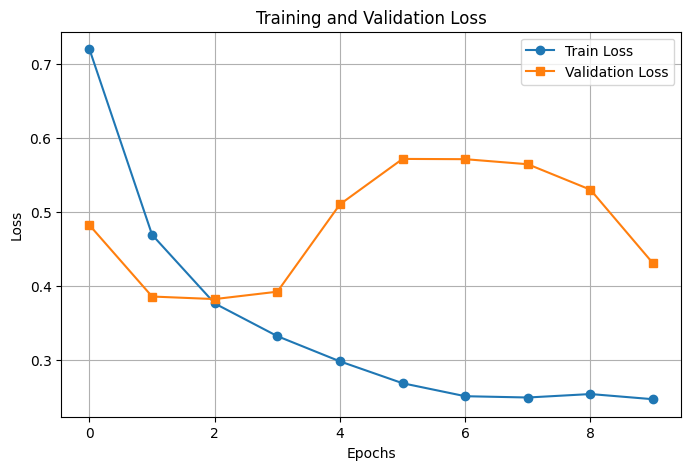

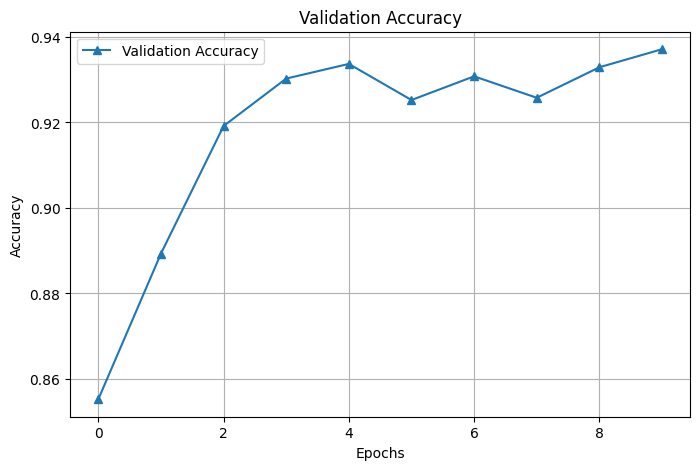

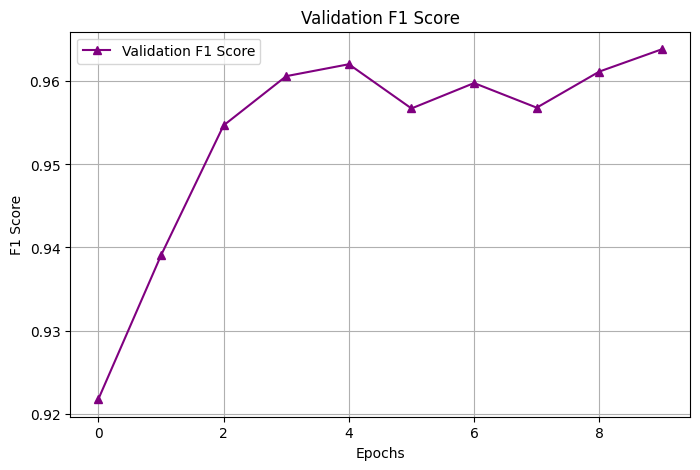

In [ ]:
# Plot training metrics
plot_training_metrics(train_losses, val_losses, val_accuracies, val_f1_scores)

**Save and Load the Model**

In [ ]:
# Save the model
torch.save(model.state_dict(), "/content/gdrive/MyDrive/CV_Final_Project/cnn.pth")

In [6]:
# Load the model for inference
model.load_state_dict(torch.load("/content/gdrive/MyDrive/CV_Final_Project/cnn.pth"))
model.eval()

<ipython-input-6-8ee38fde6136>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/gdrive/MyDrive/CV_Final_Project/cnn.pth"))


EnhancedDrowsinessCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=18432, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate precision, recall, and F1 score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
    plt.title("Confusion Matrix")
    plt.show()

Test Accuracy: 0.9158

Classification Report:
              precision    recall  f1-score   support

      drowsy       0.94      0.47      0.63       610
  non-drowsy       0.91      1.00      0.95      3417

    accuracy                           0.92      4027
   macro avg       0.93      0.73      0.79      4027
weighted avg       0.92      0.92      0.90      4027



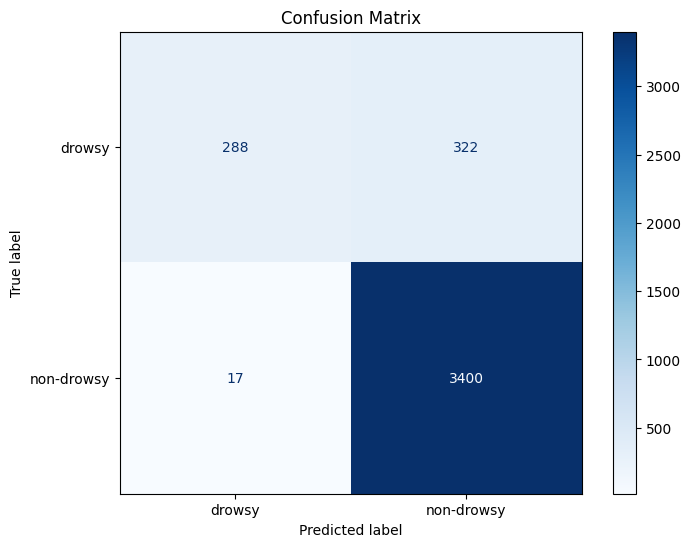

In [8]:
evaluate_model(model, test_loader)

**Predict New Images**

In [ ]:
def predict_image(image_path, model, transform, class_names, device):
    """
    Predict the class of a given image using the model.

    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Trained model.
        transform (torchvision.transforms.Compose): Transformations to apply to the image.
        class_names (list): List of class names.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        str: Predicted class label.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Apply transformations and add batch dimension
    image_tensor = transform(image).unsqueeze(0).to(device)  # Move to the same device as the model

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        predicted = (output.squeeze() > 0.5).float().item()

    return class_names[int(predicted)]

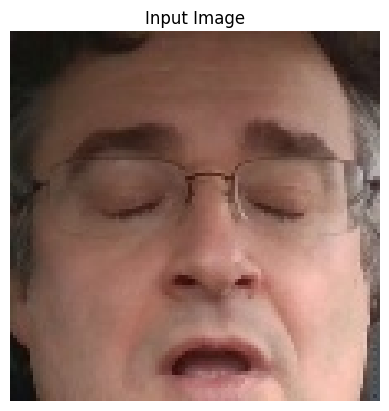

Prediction: drowsy


In [ ]:
# Ensure the model and input are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Predict on a new image
test_image_path = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames/train/drowsy/gA_1_s5_2019-03-14T14;26;17+01;00_rgb_face_frame_01374.jpg"
prediction = predict_image(test_image_path, model, transform, class_names, device)
print(f"Prediction: {prediction}")

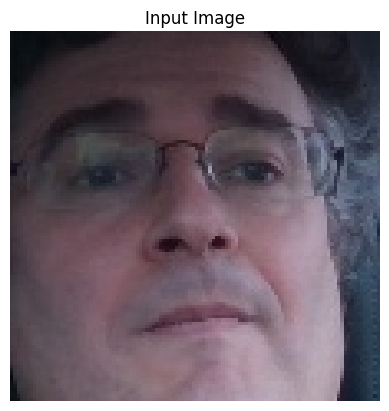

Prediction: non-drowsy


In [ ]:
# Predict on a new image
test_image_path = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames/train/non-drowsy/gA_1_s5_2019-03-14T14;26;17+01;00_rgb_face_frame_00009.jpg"
prediction = predict_image(test_image_path, model, transform, class_names, device)
print(f"Prediction: {prediction}")

**Second Trial - Conv3D CNN Model**

1. Data Preprocessing

In [9]:
class VideoFrameDataset3D(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None, sequence_length=10):
        """
        Custom Dataset for 3D CNN using sequences of frames.
        Args:
            data_dir (str): Directory where frames are stored (e.g., train, val, test).
            transform (callable, optional): Transformations to apply to each frame.
            sequence_length (int): Number of frames in each sequence.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples, self.targets = self._load_samples()  # Load samples and targets

    def _load_samples(self):
        samples = []
        targets = []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            frames = sorted(os.listdir(cls_dir))
            frame_paths = [os.path.join(cls_dir, frame) for frame in frames]
            for i in range(len(frame_paths) - self.sequence_length + 1):
                sequence = frame_paths[i:i + self.sequence_length]
                samples.append(sequence)
                targets.append(self.class_to_idx[cls])  # Append class index as target
        return samples, targets

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sequence, label = self.samples[idx], self.targets[idx]
        frames = []
        for frame_path in sequence:
            image = Image.open(frame_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            frames.append(image)
        frames = torch.stack(frames)  # Shape: (sequence_length, C, H, W)
        return frames, label


2. Model Architecture

In [10]:
class CNN3D(nn.Module):
    def __init__(self, num_classes=1):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        # Adjust the input size of the fully connected layer
        # Calculate the output size of the last Conv3D+Pool3D layer
        example_input = torch.randn(1, 3, 10, 112, 112)  # (batch_size, channels, depth, height, width)
        with torch.no_grad():
            example_output = self.pool(self.bn3(self.conv3(self.pool(self.bn2(self.conv2(self.pool(self.bn1(self.conv1(example_input)))))))))
            flattened_size = example_output.numel()  # Calculate the number of features

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).squeeze(-1)
        return x

3.Data loading and training adjustment

In [11]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Paths to train, validation, and test directories
data_base_dir = "/content/gdrive/MyDrive/CV_Final_Project/processed_videos_frames"
train_dir = os.path.join(data_base_dir, "train")
val_dir = os.path.join(data_base_dir, "val")
test_dir = os.path.join(data_base_dir, "test")

# Load datasets directly from the respective directories
sequence_length = 10
train_dataset = VideoFrameDataset3D(train_dir, transform=transform, sequence_length=sequence_length)
val_dataset = VideoFrameDataset3D(val_dir, transform=transform, sequence_length=sequence_length)
test_dataset = VideoFrameDataset3D(test_dir, transform=transform, sequence_length=sequence_length)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Compute class counts for ImageFolder dataset
train_class_counts = Counter(train_dataset.targets)  # `targets` contains the class indices for all samples
val_class_counts = Counter(val_dataset.targets)
test_class_counts = Counter(test_dataset.targets)

# Get the count for each class
drowsy_count = train_class_counts[train_dataset.class_to_idx['drowsy']]
non_drowsy_count = train_class_counts[train_dataset.class_to_idx['non-drowsy']]

# Compute class weights
class_weights = non_drowsy_count / drowsy_count
print(f"Train Dataset - Drowsy: {drowsy_count}, Non-Drowsy: {non_drowsy_count}")
print(f"Class weights (Train): {class_weights}")

# Similarly, you can print for validation and test datasets
print("Validation Dataset:", val_class_counts)
print("Test Dataset:", test_class_counts)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the 3D CNN model
model = CNN3D().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

Train Dataset - Drowsy: 1977, Non-Drowsy: 8936
Class weights (Train): 4.519979767324228
Validation Dataset: Counter({1: 3218, 0: 550})
Test Dataset: Counter({1: 3408, 0: 601})
Using device: cuda


4.Model Training

In [ ]:
def train_model2(model, train_loader, val_loader, num_epochs=10, patience=3):
    """
    Train and validate a model with early stopping.

    Args:
        model: The PyTorch model to be trained.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        num_epochs: Number of training epochs.
        patience: Number of epochs to wait for improvement before early stopping.

    Returns:
        train_losses: List of training losses per epoch.
        val_losses: List of validation losses per epoch.
        val_accuracies: List of validation accuracies per epoch.
        val_f1_scores: List of validation F1 scores per epoch.
    """
    train_losses, val_losses, val_accuracies, val_f1_scores = [], [], [], []
    best_val_loss = float('inf')
    best_model_weights = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, labels in train_loader:
            # Adjust dimensions for Conv3D: (batch_size, C, depth, H, W)
            sequences = sequences.permute(0, 2, 1, 3, 4)  # From (batch_size, sequence_length, C, H, W)
            sequences, labels = sequences.to(device), labels.to(device).float()

            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for sequences, labels in val_loader:
                # Adjust dimensions for Conv3D: (batch_size, C, depth, H, W)
                sequences = sequences.permute(0, 2, 1, 3, 4)
                sequences, labels = sequences.to(device), labels.to(device).float()

                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Collect predictions and labels for F1 score
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_f1 = f1_score(all_labels, all_preds, average="binary")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

        # Save best model weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()  # Save best weights
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        # Update learning rate
        scheduler.step()

    # Load best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)

    return train_losses, val_losses, val_accuracies, val_f1_scores


In [ ]:
# Train the model
train_losses, val_losses, val_accuracies, val_f1_scores = train_model2(
    model, train_loader, val_loader, num_epochs=10
)

Epoch 1/10, Train Loss: 0.2186, Val Loss: 0.1895, Val Accuracy: 0.9618, Val F1: 0.9781
Epoch 2/10, Train Loss: 0.1751, Val Loss: 0.3831, Val Accuracy: 0.9597, Val F1: 0.9764
Epoch 3/10, Train Loss: 0.1560, Val Loss: 0.6452, Val Accuracy: 0.9310, Val F1: 0.9587
Epoch 4/10, Train Loss: 0.1396, Val Loss: 0.5050, Val Accuracy: 0.9395, Val F1: 0.9642
Early stopping triggered.


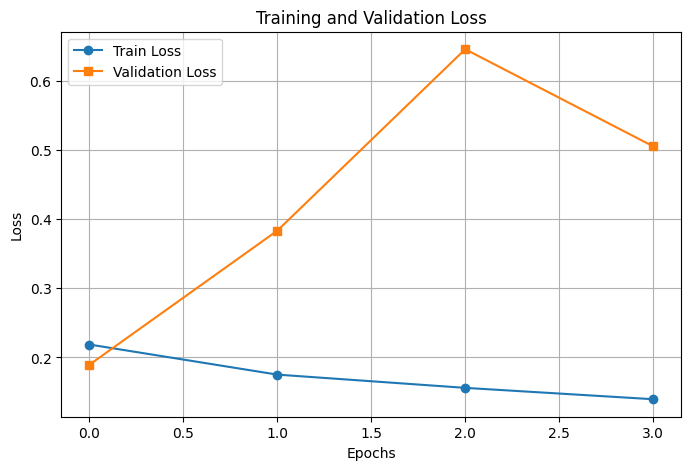

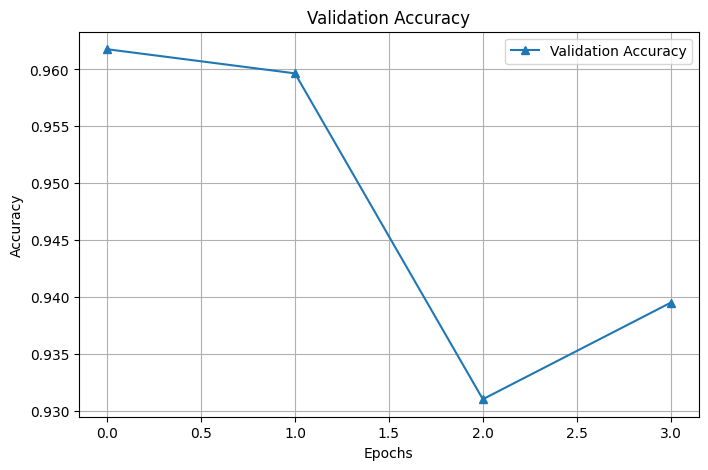

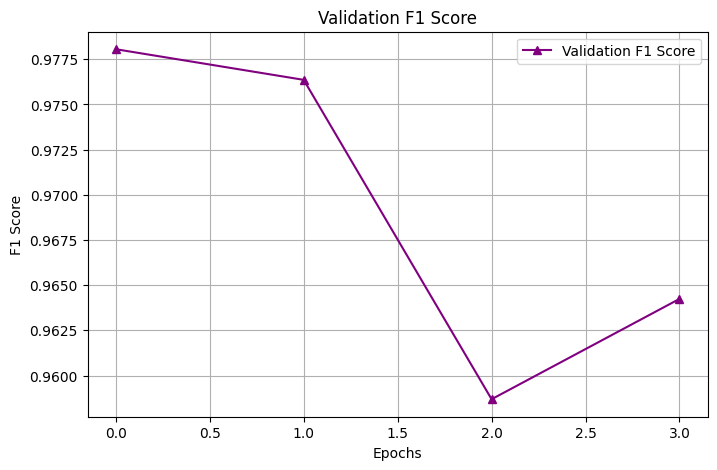

In [ ]:
# Plot training metrics
plot_training_metrics(train_losses, val_losses, val_accuracies, val_f1_scores)

5.Save and Load the Model

In [ ]:
# Save the model
torch.save(model.state_dict(), "/content/gdrive/MyDrive/CV_Final_Project/cnn2.pth")

In [12]:
# Load the model for inference
model.load_state_dict(torch.load("/content/gdrive/MyDrive/CV_Final_Project/cnn2.pth"))
model.eval()

<ipython-input-12-85722639633b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/gdrive/MyDrive/CV_Final_Project/cnn2.pth"))


CNN3D(
  (conv1): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=25088, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [13]:
def evaluate_model2(model, test_loader, class_names):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for sequences, labels in test_loader:
            # Ensure the input dimensions are correct for Conv3D
            sequences, labels = sequences.to(device), labels.to(device).float()
            sequences = sequences.permute(0, 2, 1, 3, 4)  # Convert to (batch_size, channels, depth, height, width)

            # Forward pass
            outputs = model(sequences)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate precision, recall, and F1 score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Generate and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Accuracy: 0.9189

Classification Report:
              precision    recall  f1-score   support

      drowsy       0.88      0.53      0.66       601
  non-drowsy       0.92      0.99      0.95      3408

    accuracy                           0.92      4009
   macro avg       0.90      0.76      0.81      4009
weighted avg       0.92      0.92      0.91      4009



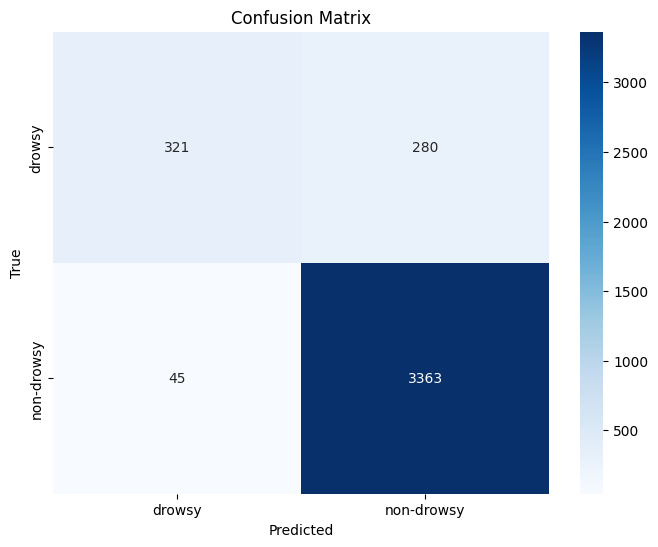

In [15]:
class_names = ['drowsy', 'non-drowsy']
evaluate_model2(model, test_loader, class_names)